In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
class PolicyEstimator():
    
    def __init__(self, learning_rate=0.01, scope='policy_estimator'):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(tf.int32, name="action")
            self.target = tf.placeholder(tf.float32, name="target")
            
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(inputs=tf.expand_dims(state_one_hot, 0), 
                                                                  activation_fn=None, 
                                                                  num_outputs=env.action_space.n, 
                                                                  weights_initializer=tf.zeros_initializer)
            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)
            
            self.loss = -tf.log(self.picked_action_prob)*self.target
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_optimzer = self.optimizer.minimize(self.loss, 
                                                          global_step=tf.contrib.framework.get_global_step())
            
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, feed_dict={self.state: state})
    
    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state:state, self.action:action, self.target:target }
        _, loss = sess.run([self.train_optimzer, self.loss], feed_dict=feed_dict)
        return loss

In [4]:
class ValueEstimator():
    
    def __init__(self, learning_rate=0.01, scope='value_estimator'):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(inputs=tf.expand_dims(state_one_hot, 0), 
                                                                  activation_fn=None, 
                                                                  num_outputs=1, 
                                                                  weights_initializer=tf.zeros_initializer)
            
            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_optimzer = self.optimizer.minimize(self.loss, 
                                                          global_step=tf.contrib.framework.get_global_step())
            
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })
    
    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_optimzer, self.loss], feed_dict)
        return loss

In [10]:
def actor_critic(env, policy_estimator, value_estimator, num_episodes, discount=1.0):
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        
        state = env.reset()
        episode = []
        for t in itertools.count():
            
            #Choose action using policy-estimator prediction
            action_probs = policy_estimator.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, end, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=end))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #Get a target from Critic: value-estimator
            value_next = value_estimator.predict(next_state)
            td_target = reward + discount*value_next
            td_error = td_target - value_estimator.predict(state)
            
            # Update the value estimator
            value_estimator.update(state, td_target)
            
            #Now improve the Actor: policy-estimator
            policy_estimator.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
#             print("\rStep {} @ Episode {}/{} ({})".format(
#                     t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]))

            if end:
                break
                
            state = next_state
    
    return stats

In [11]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats = actor_critic(env, policy_estimator, value_estimator, 300)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-08-14 21:25:03,814] From /Users/adityavyas/anaconda/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:170: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


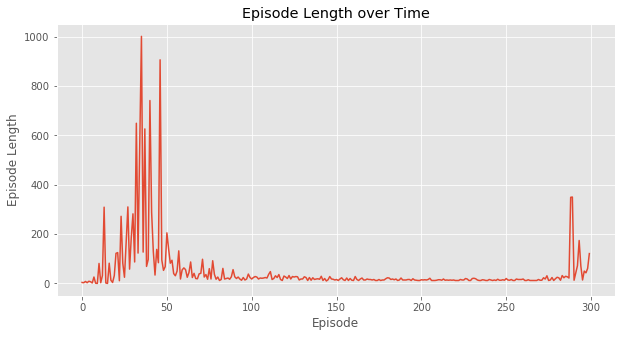

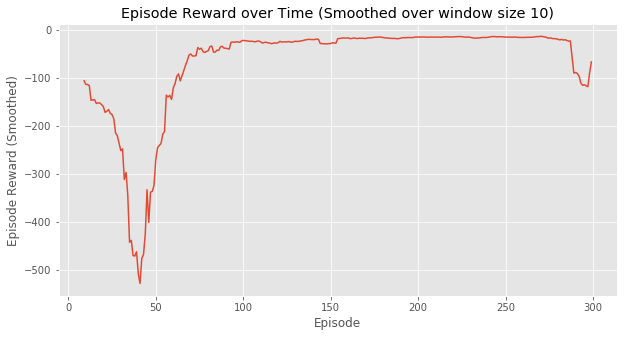

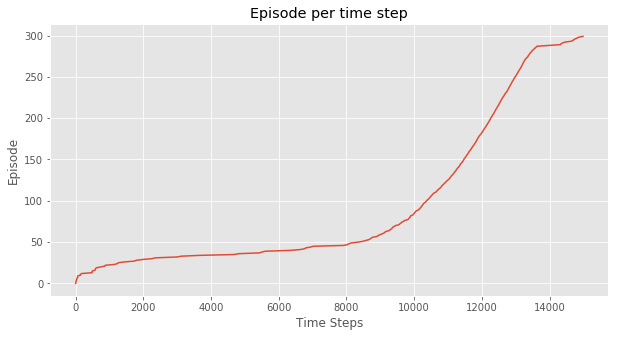

(<matplotlib.figure.Figure at 0x124871ad0>,
 <matplotlib.figure.Figure at 0x124e94d90>)

In [12]:
plotting.plot_episode_stats(stats, smoothing_window=10)